<a href="https://colab.research.google.com/github/syborg91/custom-image-classifier/blob/master/custom_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating and deploying a custom image classifier

In [25]:
import fastai
fastai.__version__

'1.0.54'

In [0]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

## 1. Libraries


In [0]:
from fastai import *
from fastai.vision import *

## 2. To download URLs of Google Images


Copy paste this in the browser console (F12) to download the URLs of all the searched Google images.

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



In [4]:
classes = ['greenwing', 'hahn', 'hyacinth', 'scarlet'] # define your classes here
files = ['urls_'+x+'.txt' for x in classes]
files

['urls_greenwing.txt',
 'urls_hahn.txt',
 'urls_hyacinth.txt',
 'urls_scarlet.txt']

In [5]:
path = 'drive/My Drive/fast.ai/macaws/' # Specify path
path = Path(path)
path.ls()

[PosixPath('drive/My Drive/fast.ai/macaws/urls_greenwing.txt'),
 PosixPath('drive/My Drive/fast.ai/macaws/urls_hahn.txt'),
 PosixPath('drive/My Drive/fast.ai/macaws/urls_hyacinth.txt'),
 PosixPath('drive/My Drive/fast.ai/macaws/urls_scarlet.txt'),
 PosixPath('drive/My Drive/fast.ai/macaws/greenwing'),
 PosixPath('drive/My Drive/fast.ai/macaws/hahn'),
 PosixPath('drive/My Drive/fast.ai/macaws/hyacinth'),
 PosixPath('drive/My Drive/fast.ai/macaws/scarlet'),
 PosixPath('drive/My Drive/fast.ai/macaws/models'),
 PosixPath('drive/My Drive/fast.ai/macaws/cleaned.csv')]

### Download Images

In [0]:
for idx, c in enumerate(classes):
    
    file = files[idx]
    download_images(path/file, path/c, max_pics=200)

### Verify and delete images

In [0]:
for c in classes:
    print('class :', c)
    verify_images(path/c, delete=True, max_workers=8)

### View data

In [6]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224,
                                 num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['greenwing', 'hahn', 'hyacinth', 'scarlet']

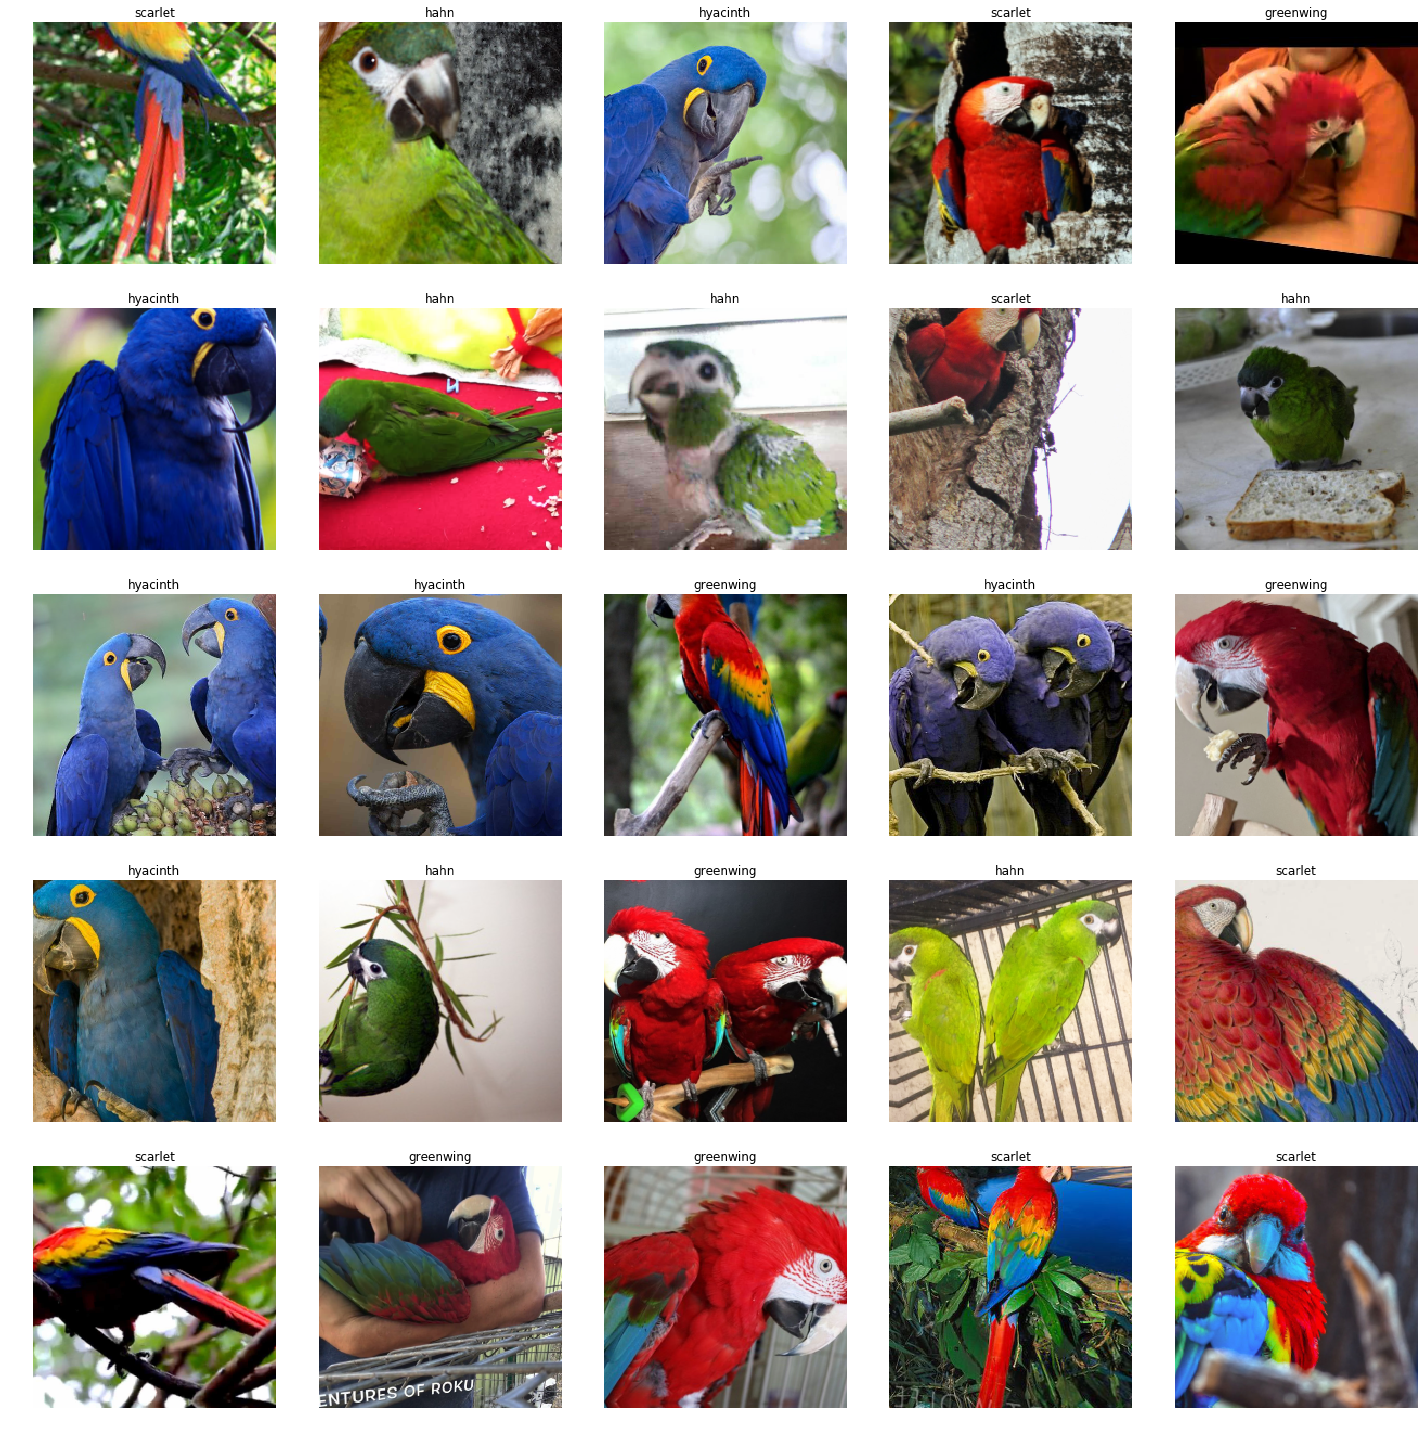

In [56]:
data.show_batch(rows=5, fig_size=(5,5))

In [57]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['greenwing', 'hahn', 'hyacinth', 'scarlet'], 4, 278, 69)

## Train Model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [37]:
# Print out the model/architecture
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [101]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [81]:
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Find an approximate mid point in the steepest downward  slope 

Min numerical gradient: 2.29E-04
Min loss divided by 10: 2.51E-04


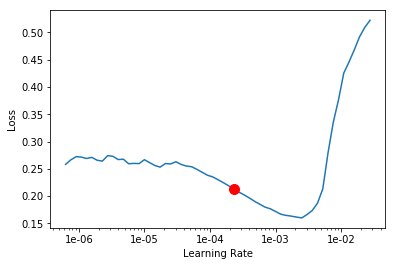

In [85]:
learn.recorder.plot(suggestion=True)

In [87]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.00022908676527677726

In [0]:
learn.load('stage-1')
learn.unfreeze()

In [99]:
learn.fit_one_cycle(2, max_lr=min_grad_lr)

In [0]:
learn.save('stage-2')

## Interpretation

In [38]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (278 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
greenwing,greenwing,greenwing,greenwing,greenwing
Path: drive/My Drive/fast.ai/macaws;

Valid: LabelList (69 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scarlet,hahn,scarlet,scarlet,scarlet
Path: drive/My Drive/fast.ai/macaws;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNo

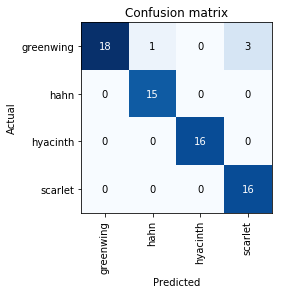

In [39]:
intrp = ClassificationInterpretation.from_learner(learn)
intrp.plot_confusion_matrix()

Around 6% error rate

In [40]:
intrp.most_confused()

[('greenwing', 'scarlet', 3), ('greenwing', 'hahn', 1)]

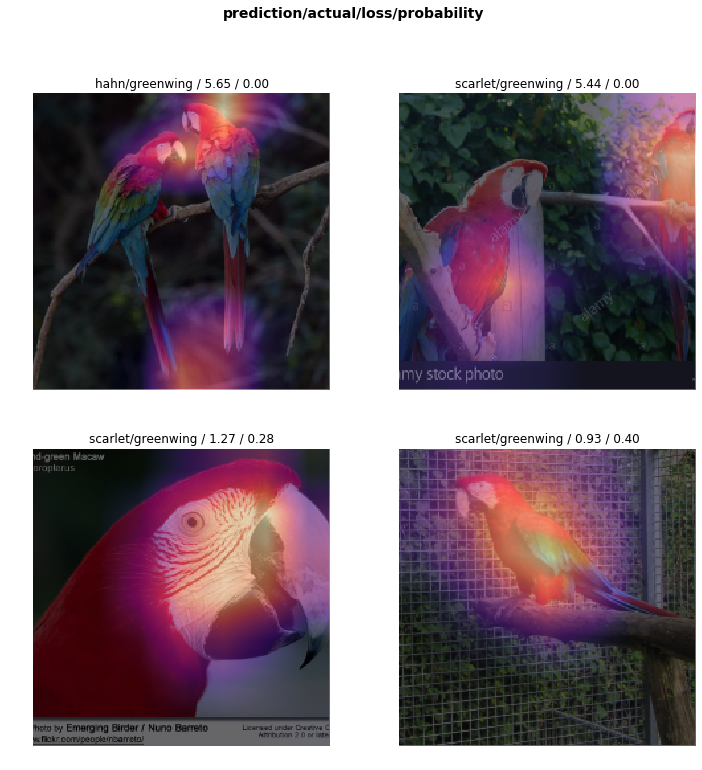

In [15]:
intrp.plot_top_losses(4)

## Cleaning Noisy Images

In [0]:
from fastai.widgets import ImageCleaner
from fastai import *

In [0]:
losses, idxs = intrp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [43]:
top_loss_paths

ImageList (69 items)
Image (3, 300, 400),Image (3, 956, 1300),Image (3, 369, 458),Image (3, 1280, 1159),Image (3, 1080, 1916)
Path: drive/My Drive/fast.ai/macaws

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [15]:
db

ImageDataBunch;

Train: LabelList (347 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hahn,hahn,hahn,hahn,hahn
Path: drive/My Drive/fast.ai/macaws;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: drive/My Drive/fast.ai/macaws;

Test: None

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
# Jupyter Widgets (ipywidgets) does not work on Colab - try local jupyter notebook!
# ImageCleaner(ds, idxs, path)

In [0]:
df = pd.read_csv(path/'cleaned.csv', header='infer')

## Deploying to Production

In [31]:
data.classes

['greenwing', 'hahn', 'hyacinth', 'scarlet']

For inference we can use CPU

In [44]:
path

PosixPath('drive/My Drive/fast.ai/macaws')

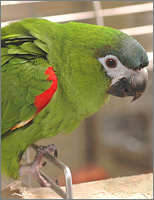

In [73]:
img = open_image(path/'hahn'/'00000014.jpg')
img

In [52]:
# Prepare ImageDataBunch with the same transformations - ideally run this once
# when the app loads
classes = ['greenwing', 'hahn', 'hyacinth', 'scarlet']
data1 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(),
                                           size=224).normalize(imagenet_stats)
learn1 = cnn_learner(data1, models.resnet34)
learn1.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: drive/My Drive/fast.ai/macaws;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: drive/My Drive/fast.ai/macaws;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [74]:
pred_class, pred_idx, outputs = learn1.predict(img)
pred_class

Category hahn

## Export Model

In [0]:
learn1.export()

This exported trained model can now be  served in the backend  for inference on the web.